In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from scipy.stats import expon,norm,boxcox
from sklearn.preprocessing import PowerTransformer
from scipy.stats.stats import pearsonr
from scipy.stats import boxcox,norm


from sklearn.model_selection import KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso,Ridge,RidgeCV
from sklearn.preprocessing import normalize,StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR


from hyperopt import STATUS_OK 
from hyperopt import hp
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin



import warnings
warnings.filterwarnings("ignore")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/bigmart-sales-data/Train.csv
/kaggle/input/bigmart-sales-data/Test.csv


In [3]:
train = pd.read_csv("../input/bigmart-sales-data/Train.csv")
test = pd.read_csv("../input/bigmart-sales-data/Test.csv")

In [ ]:
#train.head()

In [ ]:
#train.shape,test.shape

In [ ]:
#train.info()

In [4]:
def missing(df):
  number=df.isnull().sum().sort_values(ascending=False)[df.isnull().sum().sort_values(ascending=False)!=0]
  percent=number/len(df)*100
  missing_df=pd.concat((number,percent),keys=['Number','Percent'], axis=1)
  return missing_df

In [ ]:
#missing(train)

In [ ]:
#missing(test)

**1.EDA**

Text(0.5, 1.0, 'Distribution of SalePrice')

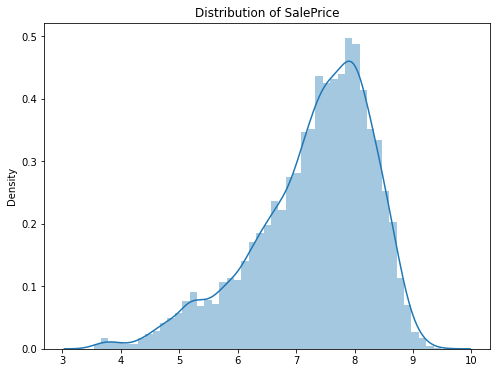

In [7]:
f,ax=plt.subplots(figsize=(8,6))
sns.distplot(x=np.log1p(train['Item_Outlet_Sales']))
ax.set_title('Distribution of SalePrice')

Text(0.5, 1.0, 'Distribution of SalePrice')

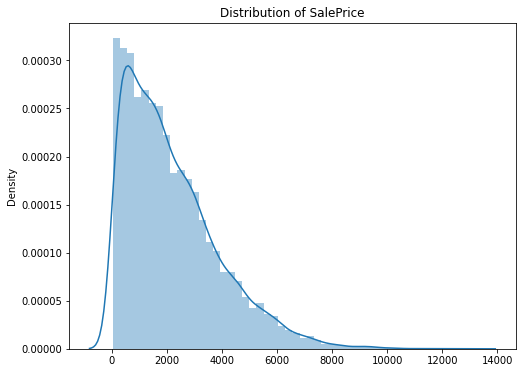

In [8]:
f,ax=plt.subplots(figsize=(8,6))
sns.distplot(x=train['Item_Outlet_Sales'])
ax.set_title('Distribution of SalePrice')

Data is right skewd we need to transform it to normal form as possible.

In [9]:
saleprice=train.Item_Outlet_Sales
saleprice.isnull().any()

False

There is no negative value ,good for us.We can use boxcox transform to normalize data.

In [10]:
norm_sale_price,fitted_lambda=boxcox(saleprice)#fitted_lambda is estimated by maximum likelyhood method

<AxesSubplot:ylabel='Density'>

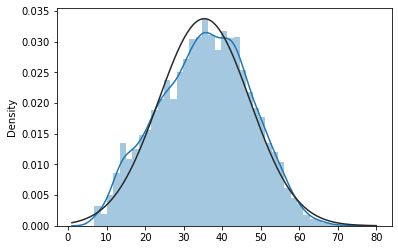

In [11]:
sns.distplot(norm_sale_price,fit=norm)

Correlation between features

Text(0.5, 1.0, 'Correlation Between Featurs')

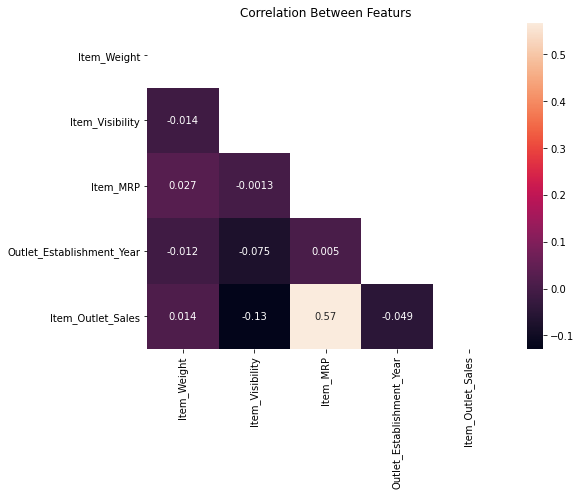

In [12]:
f,ax=plt.subplots(figsize=(8,6))
mask=np.zeros_like(train.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train.corr(),annot=True,mask=mask)
ax.set_title('Correlation Between Featurs')

<AxesSubplot:xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

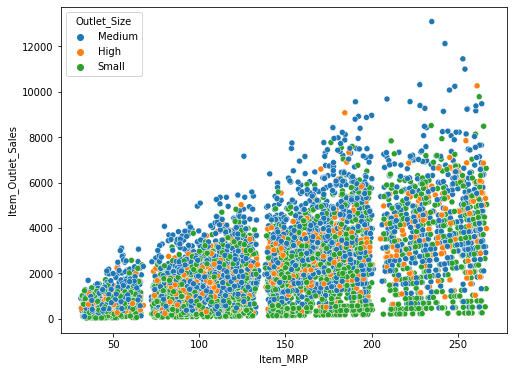

In [9]:
f,ax=plt.subplots(figsize=(8,6))
sns.scatterplot(x='Item_MRP',y='Item_Outlet_Sales',data=train,hue='Outlet_Size')

<AxesSubplot:xlabel='Outlet_Establishment_Year', ylabel='Item_Outlet_Sales'>

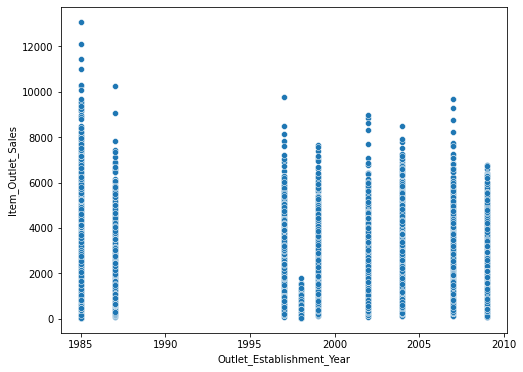

In [10]:
f,ax=plt.subplots(figsize=(8,6))
sns.scatterplot(x='Outlet_Establishment_Year',y='Item_Outlet_Sales',data=train)

<AxesSubplot:xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>

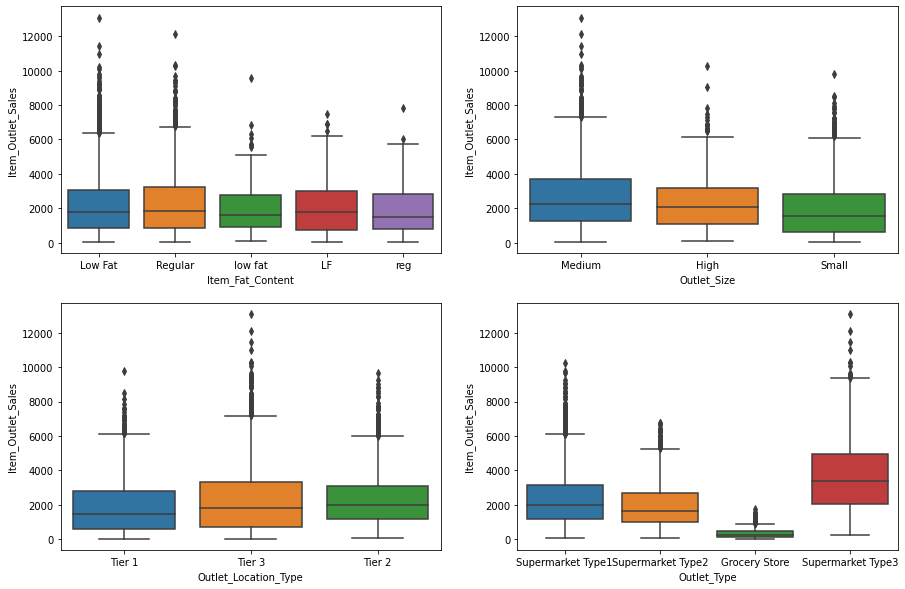

In [11]:
f,ax=plt.subplots(2,2,figsize=(15,10))

sns.boxplot(x='Item_Fat_Content',y='Item_Outlet_Sales',data=train,ax=ax[0,0])
sns.boxplot(x='Outlet_Size',y='Item_Outlet_Sales',data=train,ax=ax[0,1])
sns.boxplot(x='Outlet_Location_Type',y='Item_Outlet_Sales',data=train,ax=ax[1,0])
sns.boxplot(x='Outlet_Type',y='Item_Outlet_Sales',data=train,ax=ax[1,1])

In [13]:
train['Item_Fat_Content']=train['Item_Fat_Content'].apply( lambda x: 'Low Fat' if x in ['Low Fat','low fat','low fat'] else 'Regular')
test['Item_Fat_Content']=test['Item_Fat_Content'].apply( lambda x: 'Low Fat' if x in ['Low Fat','low fat','low fat'] else 'Regular')


<AxesSubplot:xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>

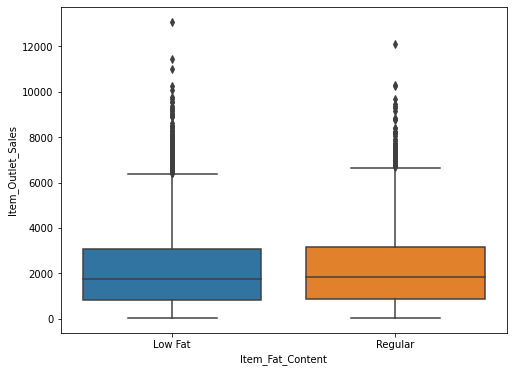

In [14]:
f,ax=plt.subplots(figsize=(8,6))
sns.boxplot(x='Item_Fat_Content',y='Item_Outlet_Sales',data=train)

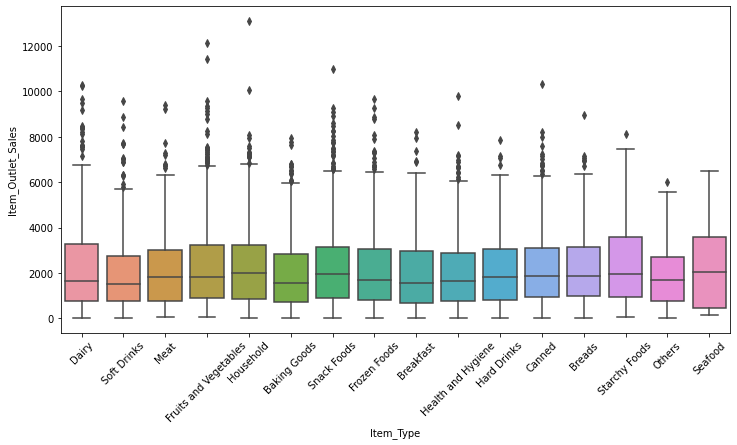

In [14]:
f, ax=plt.subplots(figsize=(12,6))

ax=sns.boxplot(x='Item_Type',y='Item_Outlet_Sales',data=train)
ax= plt.setp(ax.get_xticklabels(), rotation=45)

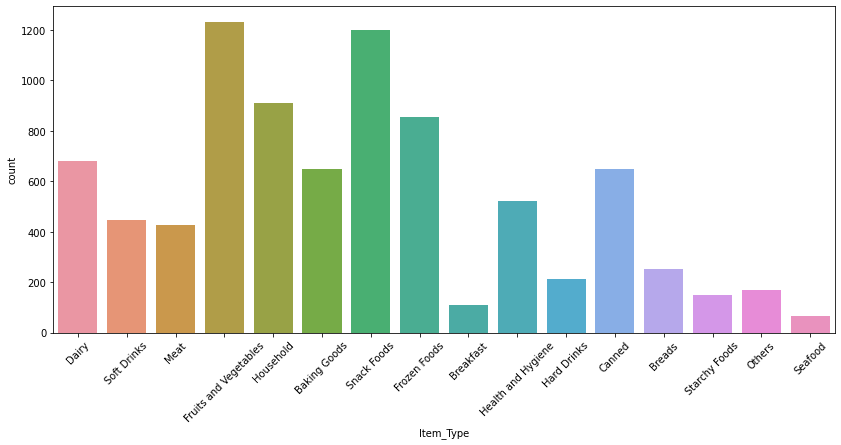

In [15]:
f,ax=plt.subplots(figsize=(14,6))

ax=sns.countplot(x='Item_Type',data=train)
ax= plt.setp(ax.get_xticklabels(), rotation=45)

<AxesSubplot:xlabel='Outlet_Location_Type', ylabel='count'>

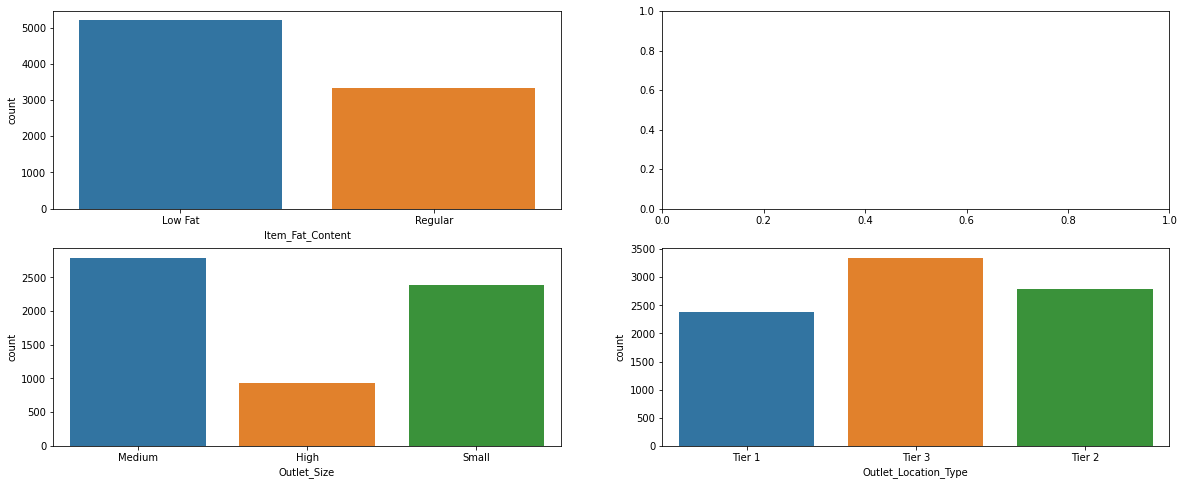

In [16]:
f,ax=plt.subplots(2,2,figsize=(20,8))
sns.countplot(x='Item_Fat_Content',data=train,ax=ax[0,0])
#sns.countplot(x='Item_Type',data=train,ax=ax[0,1])
sns.countplot(x='Outlet_Size',data=train,ax=ax[1,0])
sns.countplot(x='Outlet_Location_Type',data=train,ax=ax[1,1])

Text(0.5, 1.0, 'Number of Outlet Type Based on Location Type')

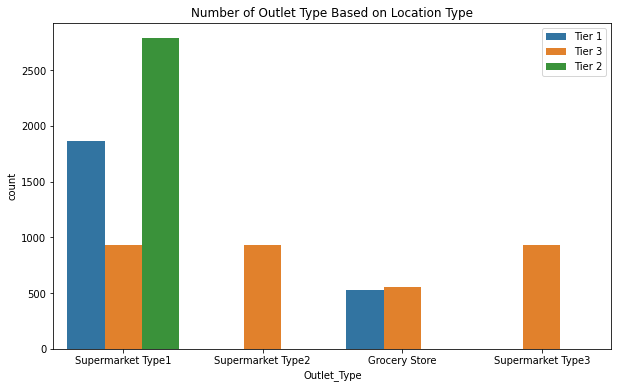

In [17]:
f,ax=plt.subplots(figsize=(10,6))
sns.countplot(x='Outlet_Type',hue='Outlet_Location_Type',data=train)
plt.legend(loc='upper right')
ax.set_title('Number of Outlet Type Based on Location Type')

Missing value Imputation

<AxesSubplot:xlabel='Item_Weight'>

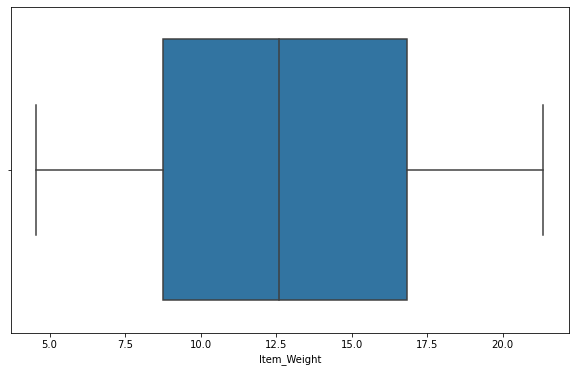

In [18]:
f,ax=plt.subplots(figsize=(10,6))
sns.boxplot(x='Item_Weight',data=train)

In [15]:
train['Item_Weight']=train['Item_Weight'].fillna(train['Item_Weight'].median())
test['Item_Weight']=test['Item_Weight'].fillna(test['Item_Weight'].median())

In [16]:
train['Outlet_Size']= train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0])
test['Outlet_Size']= test['Outlet_Size'].fillna(test['Outlet_Size'].mode()[0])

In [21]:
missing(train)

,Number,Percent


In [22]:
missing(test)

,Number,Percent


In [17]:
Item_Outlet_Sales=train['Item_Outlet_Sales']
train.drop(columns='Item_Outlet_Sales',inplace=True)

In [18]:
train.drop(columns=['Item_Identifier','Outlet_Identifier'],inplace=True)
item_indentifier=test['Item_Identifier']
test.drop(columns=['Item_Identifier','Outlet_Identifier'],inplace=True)

In [ ]:
#transformed_sale_value,calculated_lambda_value=boxcox(Item_Outlet_Sales)

In [ ]:
# sns.distplot(transformed_sale_value,fit=norm)

<AxesSubplot:ylabel='Density'>

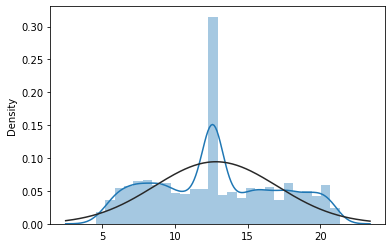

In [25]:
sns.distplot(x=train['Item_Weight'],fit=norm)

<AxesSubplot:ylabel='Density'>

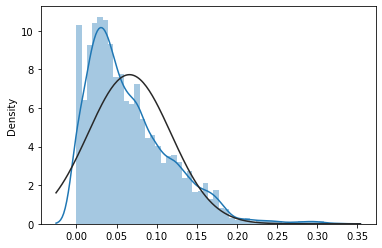

In [26]:
sns.distplot(x=train['Item_Visibility'],fit=norm)

In [19]:
any(train['Item_Visibility']==0),any(test['Item_Visibility']==0)

(True, True)

In [20]:
print(any(train['Item_Visibility']<0))
print(any(test['Item_Visibility']<0))

False
False


<AxesSubplot:ylabel='Density'>

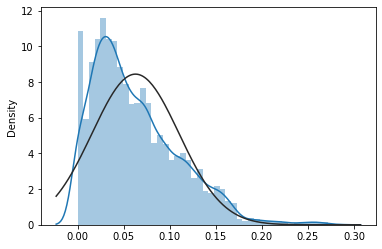

In [21]:
sns.distplot(x=np.log(train['Item_Visibility']+1),fit=norm)

<AxesSubplot:ylabel='Density'>

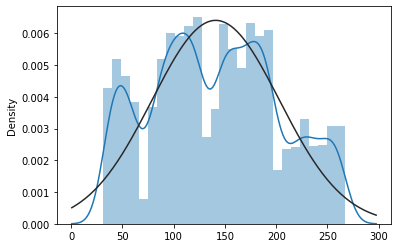

In [30]:
sns.distplot(x=train['Item_MRP'],fit=norm)

<AxesSubplot:ylabel='Density'>

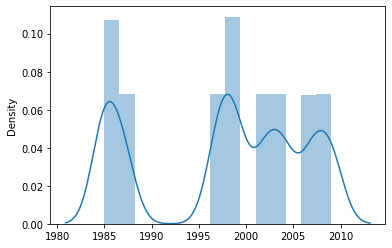

In [31]:
sns.distplot(x=train['Outlet_Establishment_Year'])

**2.Transformation and Model Building**

In [22]:
final_train=pd.get_dummies(train)
finel_test=pd.get_dummies(test)

In [23]:
X=final_train.values
y=Item_Outlet_Sales.values

In [29]:
#after scaling
sc = StandardScaler()


X_train_scaled = sc.fit_transform(final_train)
pd.DataFrame(X_train_scaled,columns=list(final_train.columns)).head()



,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,-0.831187,-0.970732,1.747454,0.139541,0.799202,-0.799202,-0.286855,-0.174193,-0.114346,-0.287094,...,-0.350395,0.798807,-0.623893,1.602840,-0.696678,-0.804732,-0.381529,0.726802,-0.349551,-0.351028
1,-1.630810,-0.908111,-1.489023,1.334103,-1.251249,1.251249,-0.286855,-0.174193,-0.114346,-0.287094,...,-0.350395,0.798807,-0.623893,-0.623893,-0.696678,1.242650,-0.381529,-1.375891,2.860816,-0.351028
2,1.108727,-0.956917,0.010040,0.139541,0.799202,-0.799202,-0.286855,-0.174193,-0.114346,-0.287094,...,-0.350395,0.798807,-0.623893,1.602840,-0.696678,-0.804732,-0.381529,0.726802,-0.349551,-0.351028
3,1.510904,-1.281758,0.660050,0.020085,-1.251249,1.251249,-0.286855,-0.174193,-0.114346,-0.287094,...,-0.350395,0.798807,-0.623893,-0.623893,-0.696678,1.242650,2.621031,-1.375891,-0.349551,-0.351028
4,-0.918719,-1.281758,-1.399220,-1.293934,0.799202,-0.799202,-0.286855,-0.174193,-0.114346,-0.287094,...,2.853918,-1.251866,-0.623893,-0.623893,-0.696678,1.242650,-0.381529,0.726802,-0.349551,-0.351028


In [31]:
y_train_scaled=sc.fit_transform((y).reshape(-1, 1))
y_train_scaled_log=np.log1p(y)

In [32]:
def evaluate(model):
  cv=KFold(n_splits=5,shuffle=True,random_state=42)
  score=-(cross_val_score(model,X_train_scaled,y_train_scaled_log,scoring='neg_mean_squared_error',cv=cv,n_jobs=-1))
  print(score)
  print(score.mean(),score.std())

In [33]:
%%time
#l1 regularization perfom feature selection
ls=Lasso()
evaluate(ls)

[1.0547099  1.06474034 1.02855522 0.97115644 1.03718825]
1.0312700303906328 0.03263657188827014
CPU times: user 50.2 ms, sys: 28.8 ms, total: 79.1 ms
Wall time: 1.65 s


In [34]:
%%time
#l2 regularization
ri=Ridge()
evaluate(ri)

[0.28354846 0.29169668 0.30416233 0.27877709 0.29117846]
0.2898726050113253 0.008629415708614993
CPU times: user 25 ms, sys: 1.99 ms, total: 27 ms
Wall time: 165 ms


In [35]:
%%time
dt=DecisionTreeRegressor()
evaluate(dt)

[0.54728961 0.56503273 0.5628127  0.58094951 0.55266708]
0.5617503258841544 0.011594214386682426
CPU times: user 27.7 ms, sys: 4.85 ms, total: 32.5 ms
Wall time: 405 ms


In [36]:
%%time
rf=RandomForestRegressor()
evaluate(rf)

[0.29535768 0.29872633 0.32681627 0.29383249 0.30123611]
0.30319377556643134 0.012090086605637825
CPU times: user 29.5 ms, sys: 4.73 ms, total: 34.3 ms
Wall time: 15.2 s


In [37]:
%%time
xgb=XGBRegressor()
evaluate(xgb)

[0.30502909 0.30848684 0.3216434  0.29771592 0.30053763]
0.30668257652361486 0.008342384534994219
CPU times: user 26.1 ms, sys: 7.06 ms, total: 33.1 ms
Wall time: 10.2 s


In [38]:
%%time
lgb=LGBMRegressor()
evaluate(lgb)

[0.2739949  0.27559885 0.29678247 0.27335213 0.28004388]
0.2799544446828637 0.008732334649109786
CPU times: user 26.8 ms, sys: 2.06 ms, total: 28.8 ms
Wall time: 10.6 s


In [39]:
%%time
stack_gen =StackingRegressor(regressors=[ri, ls, dt, rf, xgb, lgb],meta_regressor=xgb,use_features_in_secondary=True)
                              
evaluate(stack_gen)

[0.54334629 0.56857483 0.56732321 0.57573379 0.56076613]
0.5631488495161417 0.0109824034707102
CPU times: user 45.1 ms, sys: 8.93 ms, total: 54 ms
Wall time: 1min 6s


In [40]:
%%time
from sklearn.svm import SVR
svr=SVR()

evaluate(svr)

[0.28851028 0.28823719 0.31988817 0.29299268 0.28804175]
0.29553401168744137 0.012314979839531538
CPU times: user 27.6 ms, sys: 3.33 ms, total: 31 ms
Wall time: 15.8 s


**3.Hyper-parameter tunning**

3.1 Gridsearch

In [ ]:
# %%time
# from sklearn.model_selection import GridSearchCV,KFold

# cv=KFold(n_splits=5,shuffle=True,random_state=42)

# param={
#      'learning_rate':np.logspace(-3,-1,3),
#      'n_estimators':np.linspace(500,700,3,dtype=int),
#      'max_depth':np.linspace(5,8,4,dtype=int)
#  }

# xgb_gs=GridSearchCV(xgb,param_grid=param,scoring='neg_mean_squared_error',cv=cv)

# xgb_gs.fit(X_train_scaled,y_train_scaled)

In [ ]:
# xgb_gs.best_score_

In [ ]:
# %%time
# cv=KFold(n_splits=5,shuffle=True,random_state=42)
# svm_param={
#      'gamma':np.logspace(-3,1,2),
#      'C':np.linspace(0.1,10,3)
     
#  }

# svm_gs=GridSearchCV(svr,param_grid=svm_param,scoring='neg_mean_squared_error',cv=cv)

# svm_gs.fit(X_train_scaled,y_train_scaled)

In [ ]:
# svm_gs.best_score_

3.2 Random Search

3.3 Bayesian optimization

In [41]:
#defining objective function
random_state=42
cv=KFold(n_splits=5,shuffle=True,random_state=42)

def xgb_mse_cv(params, random_state=random_state, cv=cv, X=X_train_scaled, y=y_train_scaled_log):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    
   
    model = LGBMRegressor(random_state=random_state, **params)
    
    
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score

In [42]:
%%time

# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=xgb_mse_cv, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20, 
          trials=trials, 
          rstate=np.random.RandomState(random_state) 
         )

100%|██████████| 20/20 [06:46<00:00, 20.33s/trial, best loss: 0.2786436501141504]
CPU times: user 585 ms, sys: 59.3 ms, total: 644 ms
Wall time: 6min 46s


In [43]:
best

{'learning_rate': 0.009516355818546441,
 'max_depth': 17.0,
 'n_estimators': 964.0}

In [44]:
model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])

In [45]:
X_test_scaled = sc.fit_transform(finel_test)

In [46]:
model.fit(X_train_scaled,y_train_scaled_log)

LGBMRegressor(learning_rate=0.009516355818546441, max_depth=17,
              n_estimators=964, random_state=42)

In [47]:
scaled_prediction=model.predict(X_test_scaled)

In [48]:
predicted_saleprice=np.floor(np.expm1(scaled_prediction))

In [53]:
predicted_saleprice

array([1420., 1193.,  495., ..., 1573., 3823., 1230.])

In [54]:
predicted_saleprice=pd.Series(predicted_saleprice)

In [63]:
Predicted_price=pd.concat([item_indentifier,predicted_saleprice],keys=['Item_Identifier','Predicted_Sale'],axis=1)

In [64]:
Predicted_price.head()

,Item_Identifier,Predicted_Sale
0,FDW58,1420.0
1,FDW14,1193.0
2,NCN55,495.0
3,FDQ58,2162.0
4,FDY38,5496.0
